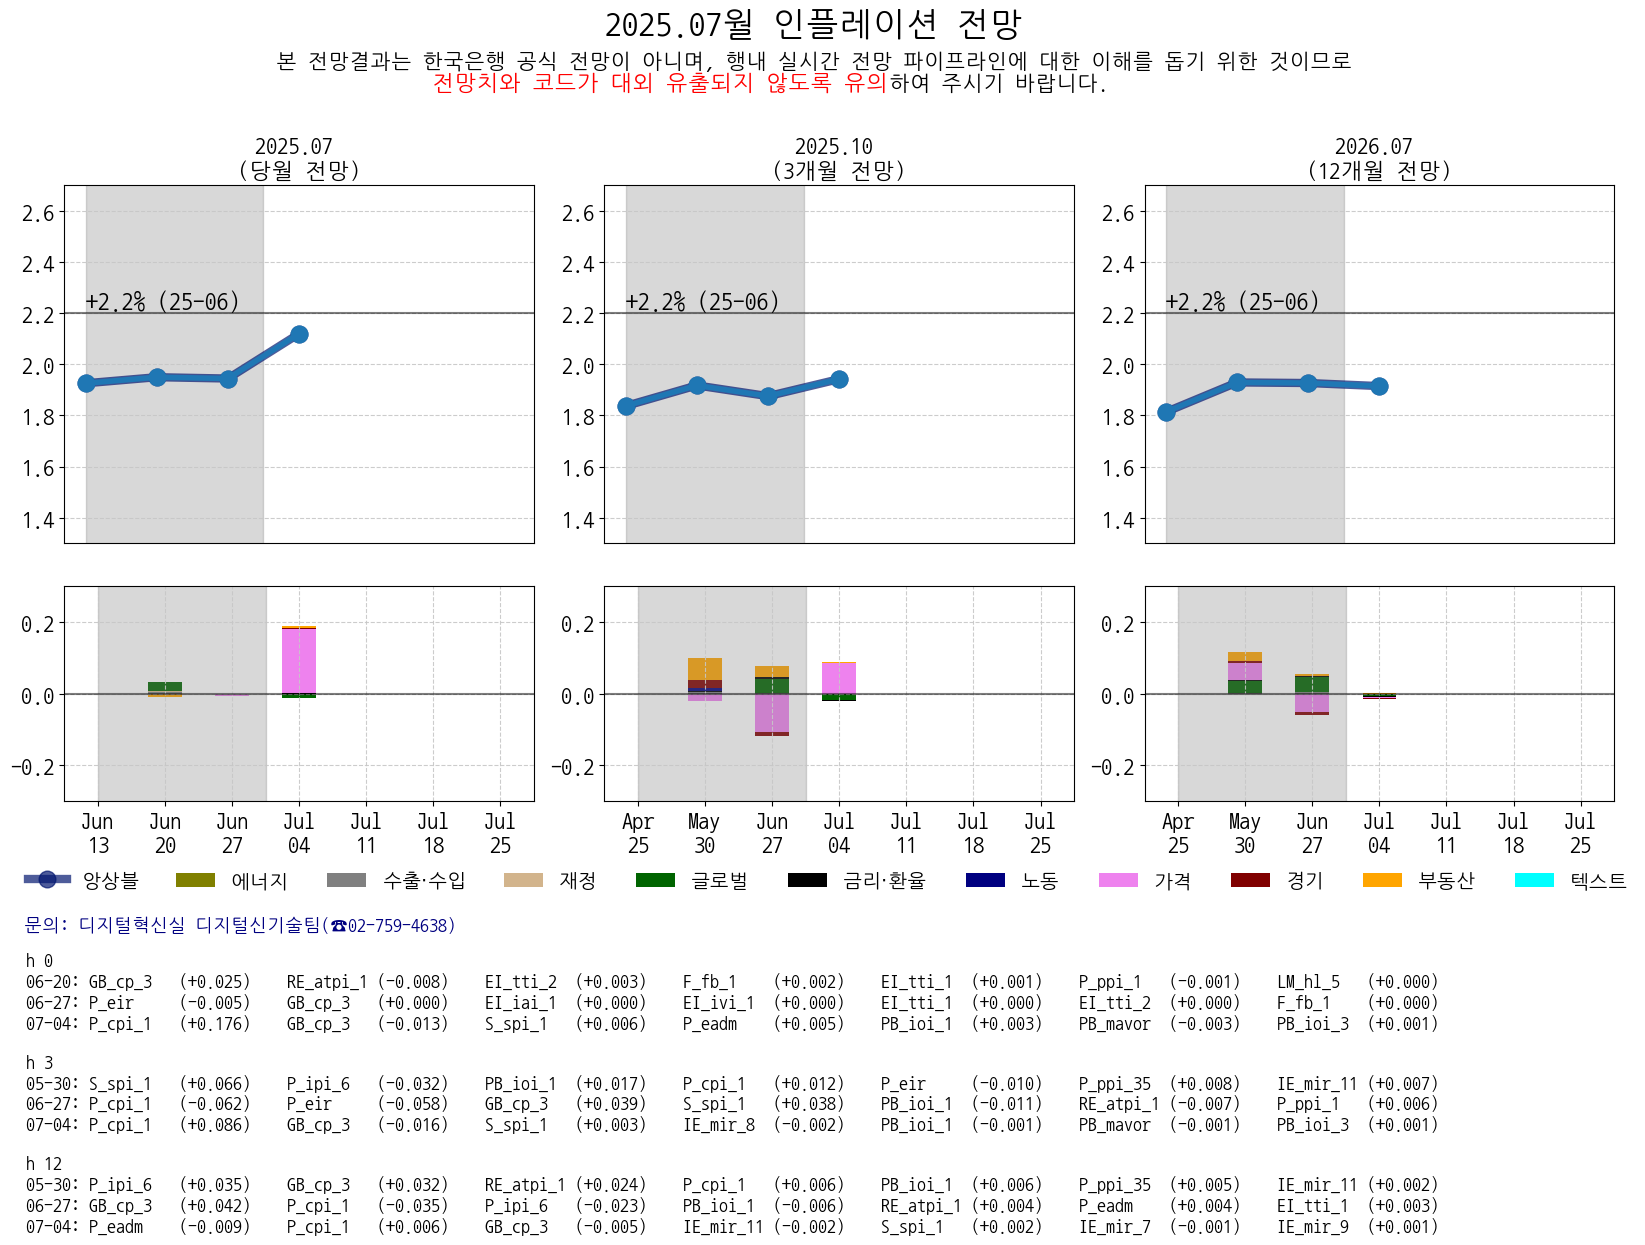

In [1]:
from IPython.display import Image, display
display(Image(filename='plot/inf_latest.png'))

# 참고
- 연구자: 디지털혁신실 이창훈, 홍지연, 이현창
- [[Gitlab 디지털신기술팀/inflation_forecasting]](https://bidas-gitlab.boknet.intra/digitaltech/inflation_forecasting) 페이지에서 실시간 인플레이션 전망 파이프라인의 모든 코드와 데이터를 확인할 수 있음
- BOK 이슈노트 "[제2024-5호] 빅데이터와 기계학습 알고리즘을 활용한 실시간 인플레이션 전망(real-time inflation forecasting)"[[💾이슈노트 다운로드]](https://bidas-s3.boknet.intra/newtech/public/inf_nowcasting/이슈노트2024-5호.pdf)
- 변수별 기여도분해 관련 예측변수 ID의 정확한 변수명은 엑셀파일 참고<a href="https://bidas-s3.boknet.intra/newtech/public/inf_nowcasting/data_id_list.pdf" download>[💾변수리스트 다운로드]</a>

## 시스템 개요
- ### 시각화된 실시간 전망결과를 통해 향후 물가 경로에 대한 정보 제공
    - 매주 금요일마다 새로 입수된 데이터를 이용하여 당월, 3개월, 12개월 인플레이션 전망치를 업데이트하고, 변수별 기여도 분해
- ### 머신러닝 알고리즘(EXT)과 선형회귀모형의 앙상블 적용
    - 머신러닝 알고리즘은 빅데이터 활용 및 모형 식별 오류 문제 해결에 적합하며, 선형회귀모형은 데이터 수가 충분하지 않은 경우, 상대적으로 뛰어난 예측성능
    - 앙상블 기법(EXT와 선형회귀모형 전망치의 평균)을 이용하여 예측성능 개선
- ### 파이썬/주피터노트북/Gitlab 및 컨테이너 기술 활용
    - 애자일한 전망모형 개발, 운영 자동화, 전망결과 및 개발노하우 공유, 축적에 용이   

# 과거시점 실시간 인플레이션 전망결과 조회
- 아래 셀 두번째 줄 display(Image(filename='plot/inf_연도.월.png')) 코드를 수정하여 조회 또는 마지막 셀의 '실시간 인플레이션 전망 대시보드' 참고
- ex) 2021년 7월 전망결과는 inf_2021.07로 조회
- 2020.08 ~ 현재월 까지 조회 가능
- 디폴트로 현재월 직전 2개월 과거 전망 결과를 plot

In [2]:
from datetime import datetime
this_year = datetime.now().year
last_month = datetime.now().month - 1

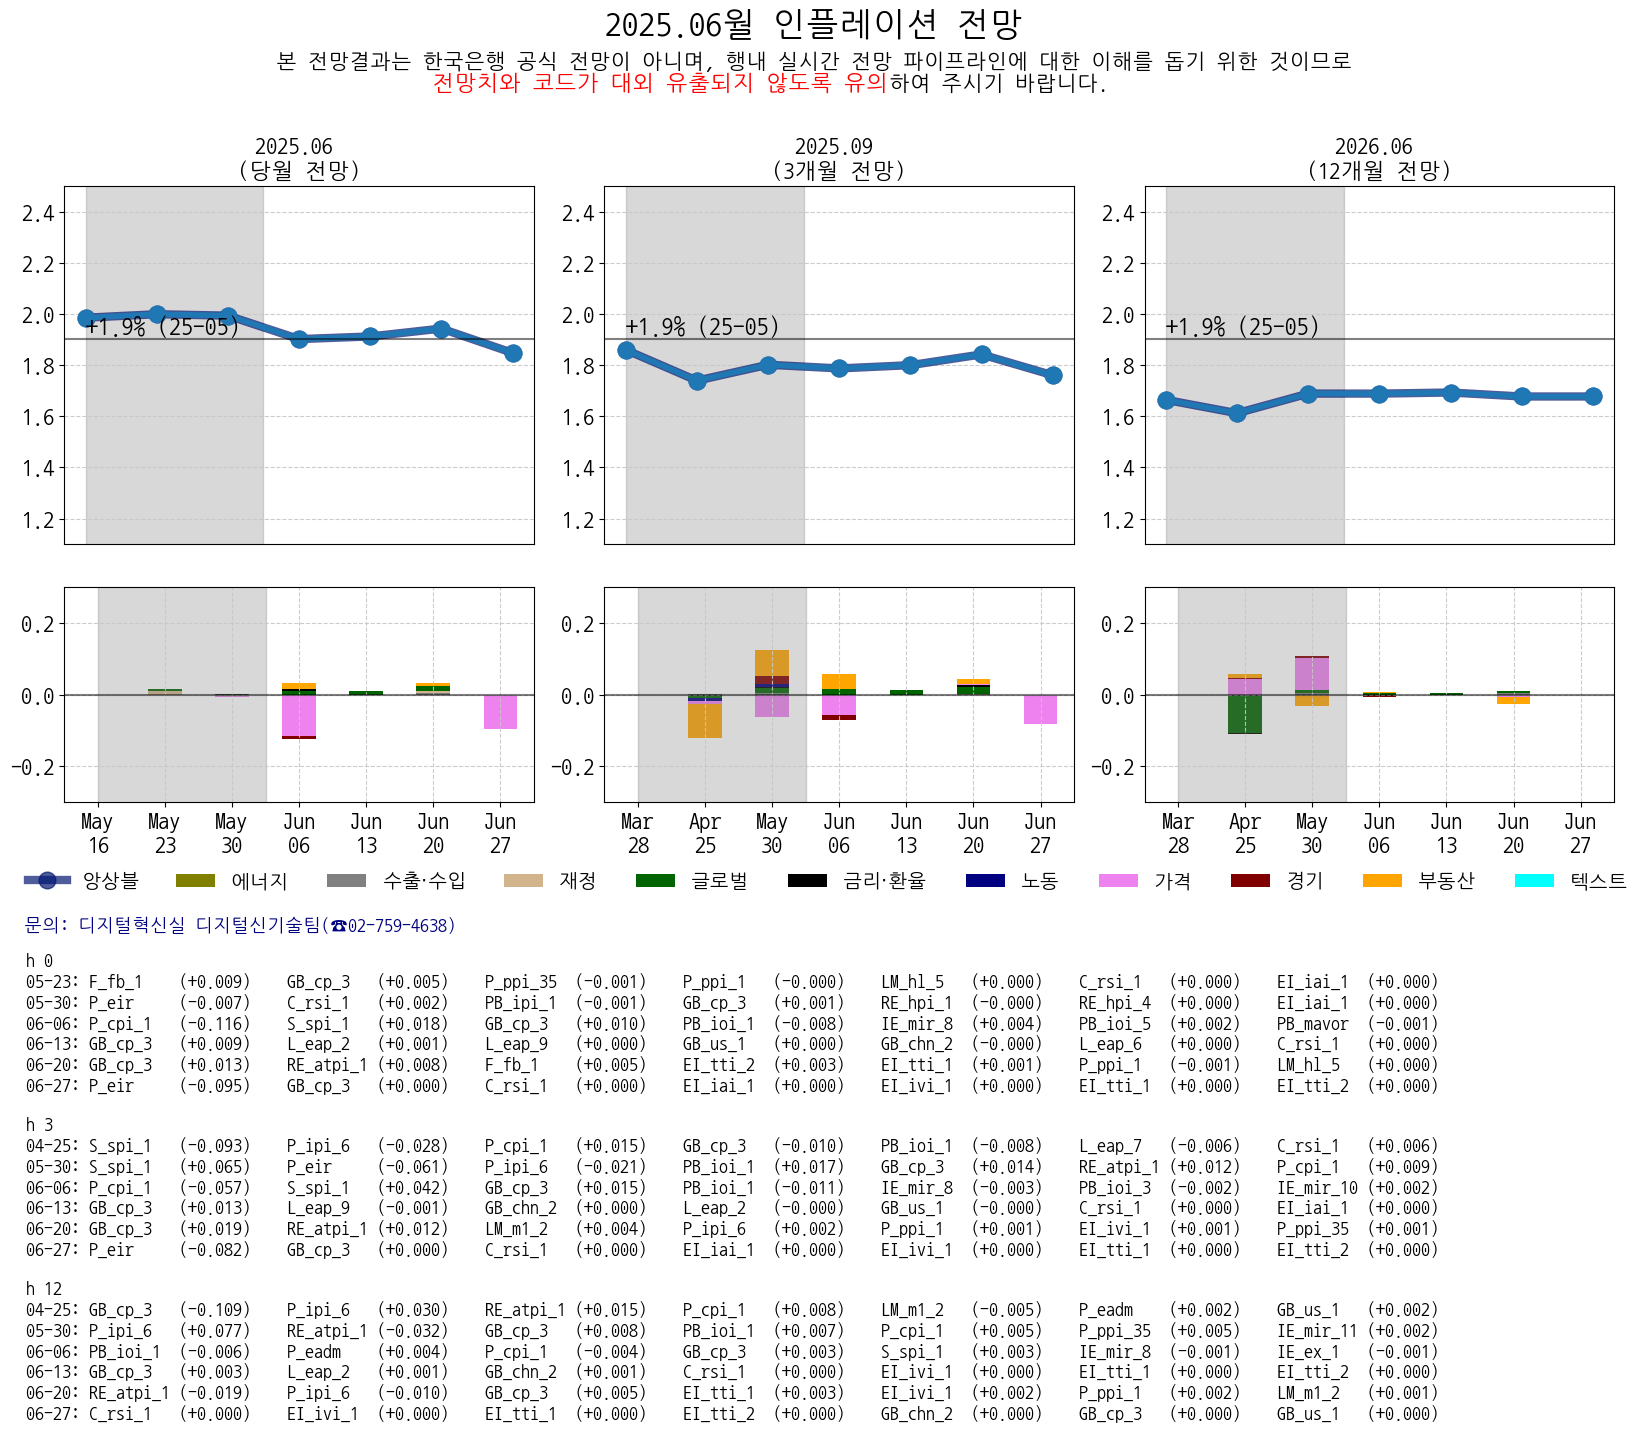

In [3]:
from IPython.display import Image, display
try:
    display(Image(filename=f'plot/inf_{this_year}.{str(last_month).zfill(2)}.png'))
except:
    display(Image(filename=f'plot/inf_2024.12.png'))

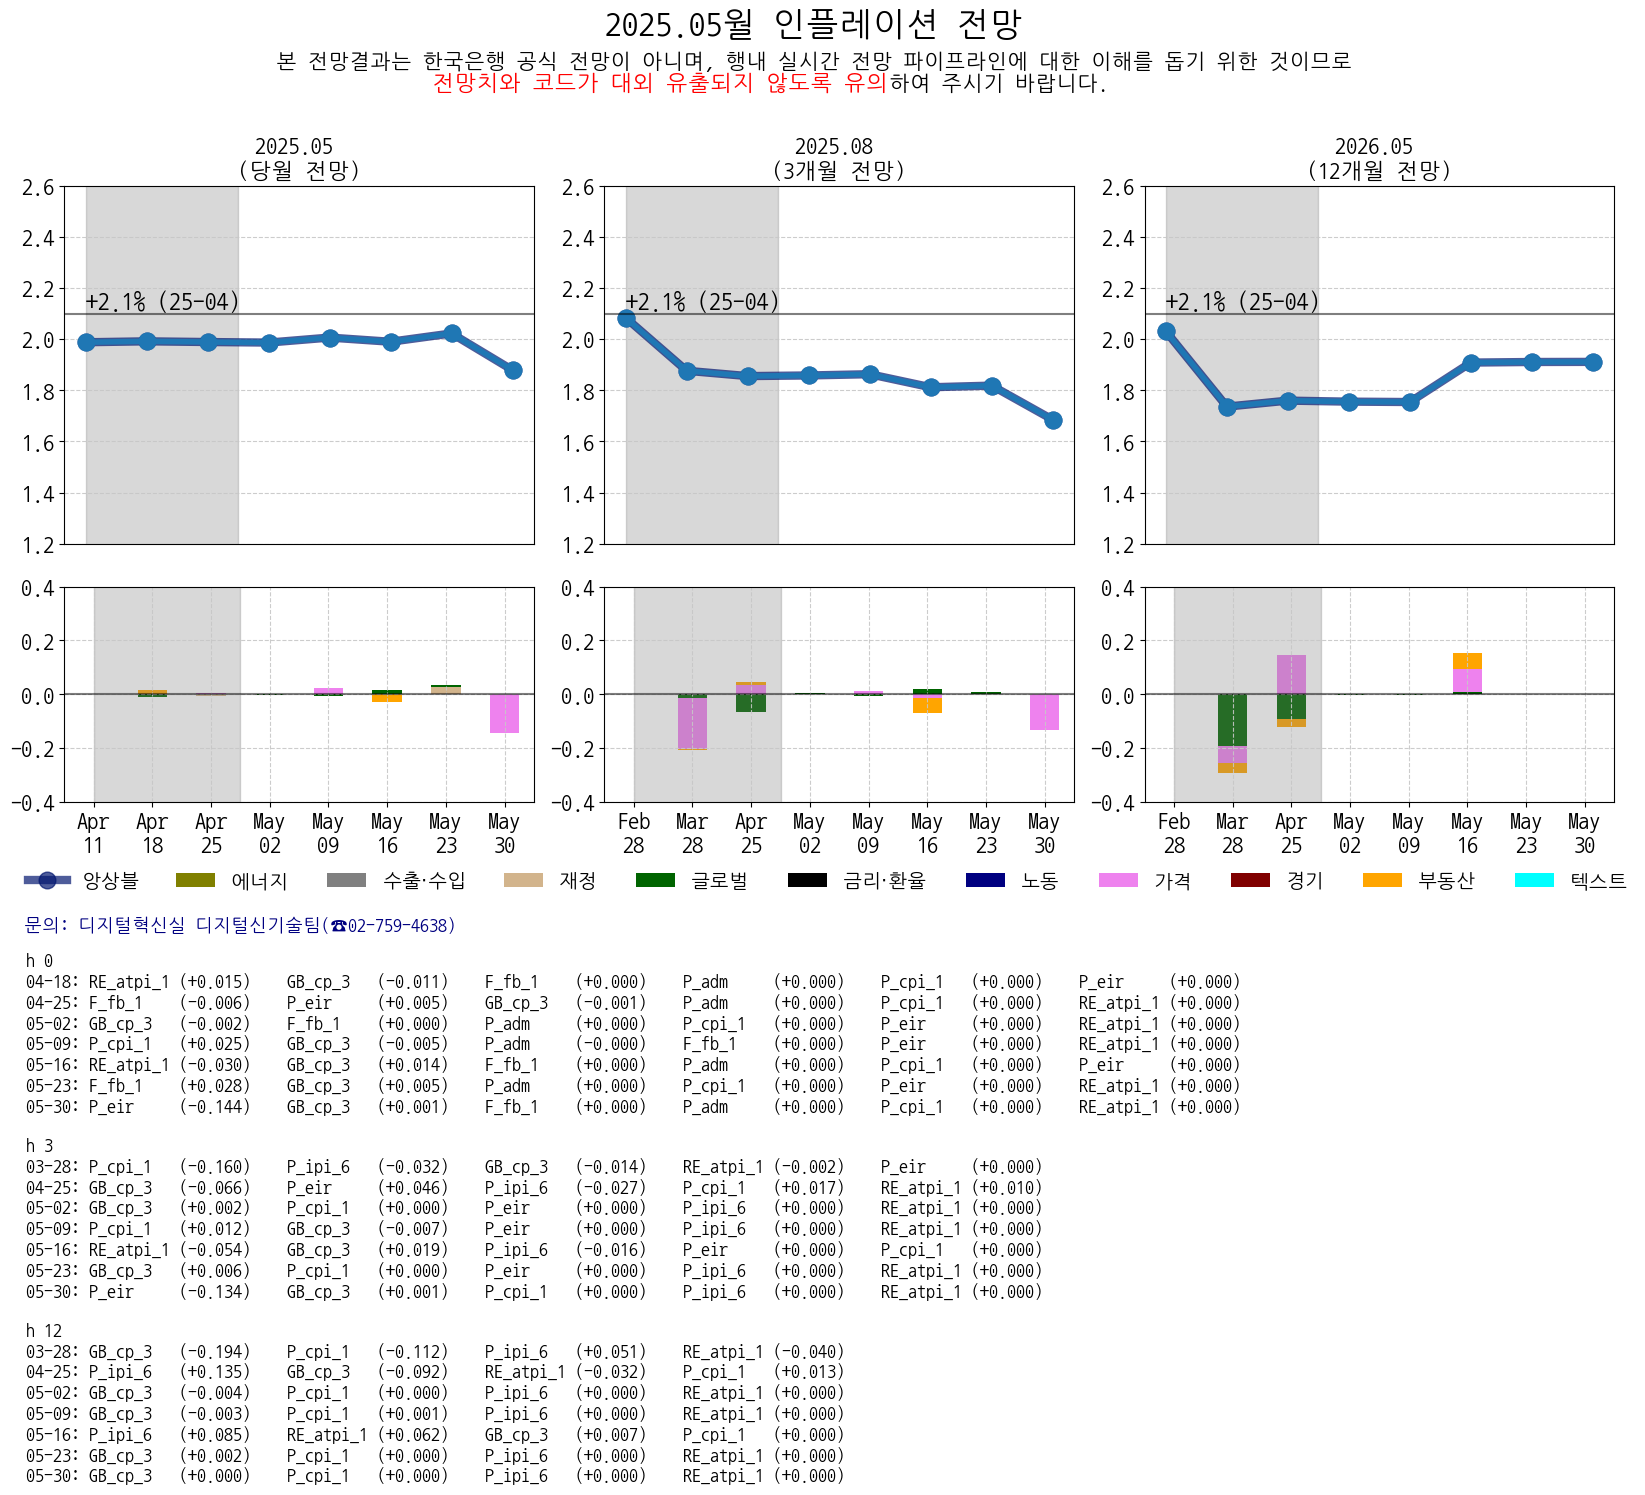

In [4]:
from IPython.display import Image, display
try:
    display(Image(filename=f'plot/inf_{this_year}.{str(last_month-1).zfill(2)}.png'))
except:
    display(Image(filename=f'plot/inf_2024.11.png'))

# 모델 학습 및 표본외 예측력 평가(매년 재추정)

- 2016년 1월부터 모형추정 및 실시간 전망 수행

In [5]:
import import_ipynb
from train_models import *

importing Jupyter notebook from train_models.ipynb


In [6]:
DO_TRAIN = False
DO_HYPERPARAMETER_TUNE = False # if True, train models with all hyperparameter combinations. if False, only train best models
GET_EVALUATION_PLOT = False

In [7]:
local_path = set_local_path()

In [8]:
model_types = ['reg', 'ext'] #['arima', 'rw', 'reg', 'ext']

if DO_TRAIN:
    train_models(model_types, DO_HYPERPARAMETER_TUNE) 
    predict_and_plot(model_types, GET_EVALUATION_PLOT)

# 우리나라 2017년부터 인플레이션 실제치

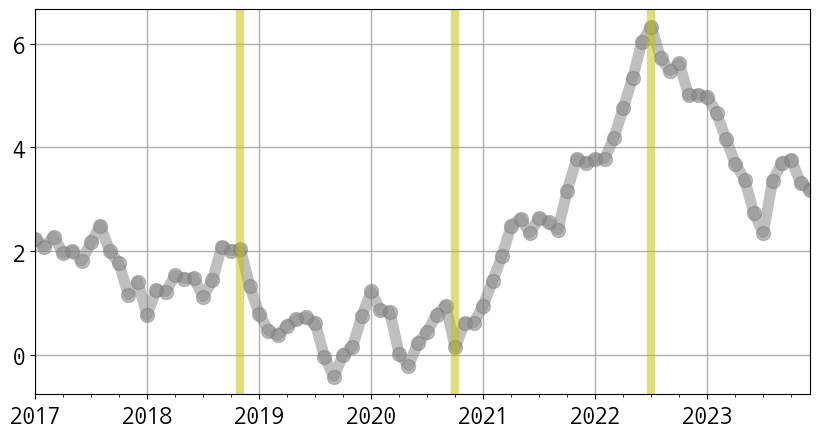

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
for ax, h in zip([axs], [0]):
    act[targets].loc['2017':].plot(ax=ax, lw=8, color='gray', marker='o', markersize=10, alpha=0.5)
    ax.grid(which='major', lw=1)
    ax.tick_params(axis="both", labelsize=18)
    for x in ['2018-11-30', '2020-10-31', '2022-07-31']:
        ax.axvline(x=x, lw=6, color='y', alpha=0.5)

# 전망시계별 전망모형

In [10]:
ens_models = get_ens_models()
ens_best = get_best_ens_models(ens_models)

In [11]:
today = pd.Timestamp(datetime.now().strftime('%Y-%m-%d'))
vintages = pd.date_range('2012-12-02', today, freq='W-FRI')

_, act_vintage = get_train_data_v5(DF_vintages[vintages[-1]])

#######수정필요: BIDAS에 25년 4월 소비자물가지수 업뎃되지 않아 임의수정################
act_vintage['2025-04-30'] = 2.1
######################################################################################

last_inf_month = act_vintage.dropna().index[-1]
last_inf = act_vintage.dropna().iloc[-1]
print(f"The latest inflation is {last_inf:.2f} for {last_inf_month:%Y-%m}")

#this_month = (pd.Timestamp(datetime.now()) - timedelta((datetime.now().weekday() + 3)%7)).strftime('%Y-%m')
this_month = last_inf_month + MonthBegin(1) # inf 실제치가 존재하는 월의 그 다음달 기준으로 예측

The latest inflation is 2.17 for 2025-06


# 기여도분해

In [12]:
from collections import OrderedDict

In [13]:
for month in [this_month]:
    fm = month + MonthEnd(0)
    
    if today.strftime('%Y-%m-%d') != vintages[-1].strftime('%Y-%m-%d'):
        print(f"{today} is not Friday.")
        continue

    for h in [0, 3, 12]:

        tm = fm + MonthEnd(h)
        model_names = ens_models[ens_best[h]] # h=0: ens103, h=3: ens1005, h=12: ens35}
        print(model_names)
        print(f"\nhor : {h} months, fm : {fm:%Y-%m}, tm : {tm:%Y-%m}")
        print(', '.join(model_names))

        PRED_DECOMP = pd.DataFrame()
        
        print(f'{fm:%Y-%m-%d}')


        for mname in model_names:
            print(f"\ndecomposing {mname} ...")
            try:
                download_from_s3(f"{s3_repo_path}/model/{mname}_{tm.year}-01_h{h}.pkl", f"{local_path}/model/")
                model = joblib.load(f"{local_path}/model/{mname}_{tm.year}-01_h{h}.pkl")
                
            except:
                print(f"Model for {tm.year - 1} is loaded instead of {tm.year}, which does NOT exist.")
                    
                try:
                    download_from_s3(f"{s3_repo_path}/model/{mname}_{tm.year - 1}-01_h{h}.pkl", f"{local_path}/model/")
                    model = joblib.load(f"{local_path}/model/{mname}_{tm.year - 1}-01_h{h}.pkl")
                except:
                    print("Model NOT exist!!")
                    continue

            fm_vintages = [date for date in vintages if (date.month == fm.month) and (date.year == fm.year)]
            if vintages[-1] not in fm_vintages: # 공표 전에 월이 바뀐경우, 전 달에 이어서 생성
                fm_vintages.append(vintages[-1])
                
            if h == 0:
                pm = fm - MonthEnd(1)
                pm_vintages = [Nth_friday(pm.year, pm.month, i) for i in [-3, -2, -1]]
            else:
                pm_vintages = [Nth_friday(m.year, m.month, -1) for m in [fm - MonthEnd(i) for i in [3, 2, 1]]]

            decomp_vintages = pm_vintages + fm_vintages
            #decomp_vintages = list(set(decomp_vintages)) # 중복제거
            decomp_vintages = list(OrderedDict.fromkeys(decomp_vintages))
            
            pred = pd.DataFrame(index=decomp_vintages, columns=['forecast'])

            rolling = int(mname.split('_roll')[1].split('_')[0])
            lag = int(mname.split('_lag')[1].split('_')[0])

            if mname.split('_')[0] == 'lm':
                data_group = mname.split('_model')[1].split(':')
                excl_alt = False
            else:
                data_group = int(mname.split('_g')[1].split('_')[0])
                excl_alt = True

            df0 = DF_vintages[decomp_vintages[0]].copy()
            X0, _ = get_train_data_v5(df0, lag, data_group, excl_alt, fm, rolling=rolling)

            if mname.split('_')[0] == 'lm':
                pred0 = model.predict(X0.loc[[fm]])[0]
            else:
                if h == 12:
                    X0 = X0.drop(['P_eir'], axis = 1)
                else:
                    pass
                pred0 = model.predict(X0.loc[[fm]])[0] + last_inf

            decomp = pd.DataFrame(index=decomp_vintages[1:], columns=df0.columns)
            pred.loc[decomp_vintages[0], 'forecast'] = pred0

            for v in decomp_vintages[1:]:
                print(f"{v:%m-%d}", end=' ')
                df1 = DF_vintages[v].copy()

                for col in df0.columns: ####################
                    df0 = df0.reindex(df1.index)
                    try:
                        df0.loc[:, col] = df1.loc[:, col].copy()
                    except:
                        pass

                    X1, _ = get_train_data_v5(df0, lag, data_group, excl_alt, fm, rolling=rolling)
                    if mname.split('_')[0] == 'lm':
                        pred1 = model.predict(X1.loc[[fm]])[0]
                    else:
                        if h == 12:
                            X1 = X1.drop(['P_eir'], axis = 1)
                        else:
                            pass
                        pred1 = model.predict(X1.loc[[fm]])[0] + last_inf
                    diff = pred1 - pred0
                    if np.abs(diff) > 0.001:
                        print(f"({col}){diff:.3f}", end=' ')
                    decomp.loc[v, col] = diff
                    pred0 = pred1

                pred.loc[v, 'forecast'] = pred1
                print(f"({pred1:.3f})")

            decomp = decomp.applymap(lambda x: np.nan if np.abs(x) < 0.0001 else x)
            decomp = decomp.dropna(how='all', axis=1)
            pred_decomp = pd.concat([pred, decomp], axis=1)
            pred_decomp = pd.concat([pred_decomp], axis=1, keys=[mname])
            PRED_DECOMP = pd.concat([PRED_DECOMP, pred_decomp], axis=1)

        PRED_DECOMP.to_pickle(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
        upload_to_s3(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl", output_s3_dir)

['lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3', 'lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3', 'ext_roll0_lag0_d10_g1']

hor : 0 months, fm : 2025-07, tm : 2025-07
lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3, lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3, ext_roll0_lag0_d10_g1
2025-07-31

decomposing lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3 ...
06-20 (GB_cp_3)0.039 (F_fb_1)0.007 (1.890)
06-27 (P_eir)-0.002 (1.888)
07-04 (P_cpi_1)0.257 (GB_cp_3)-0.020 (2.124)

decomposing lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3 ...
06-20 (RE_atpi_1)-0.025 (GB_cp_3)0.038 (1.820)
06-27 (P_eir)-0.017 (1.803)
07-04 (P_cpi_1)0.271 (GB_cp_3)-0.018 (2.056)

decomposing ext_roll0_lag0_d10_g1 ...
06-20 (P_ppi_1)-0.002 (LM_hl_5)0.001 (EI_tti_1)0.004 (EI_tti_2)0.010 (GB_cp_3)-0.002 (2.139)
06-27 (P_eir)0.003 (2.142)
07-04 (P_eadm)0.015 (PB_mavor)-0.008 (PB_ioi_1)0.008 (PB_ioi_3)0.002 (IE_mir_9)0.002 (IE_mir_8)0.001 (S_spi_1)0.017 (2.178)
['l

# 실시간 인플레이션 전망 대시보드
- 과거시점의 전명결과를 출력하려면 아래 셀 첫번째 줄의 present_results = False로 수정한 후, 두번째 줄의 마지막 '연도-월-1'을 원하는 시점으로 수정
- ex) 2022년 7월 전망결과는

      present_results = False
      
      year_month = this_month if present_results else '2022-7-1' 로 조회할 수 있음

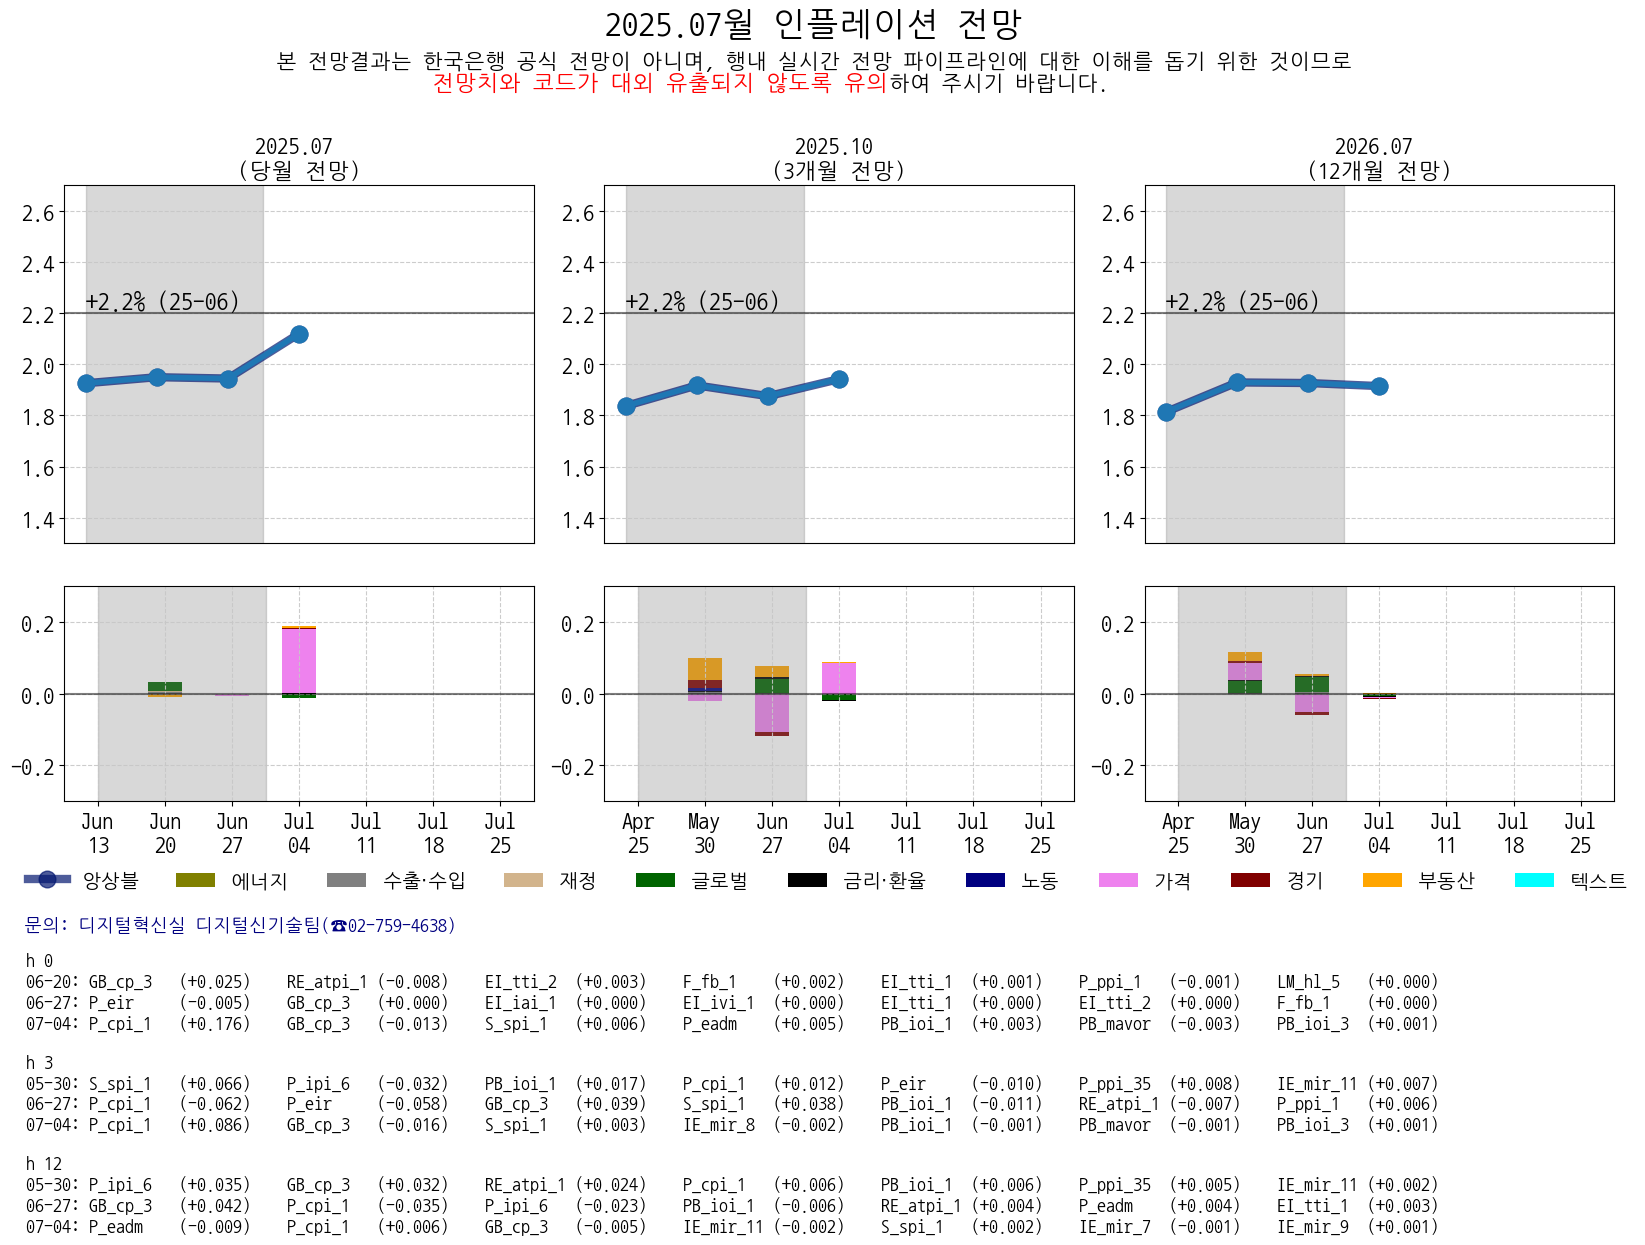

In [14]:
present_results = True
year_month = this_month if present_results else '2024-5-1'
    
fm = pd.Timestamp(year_month) + MonthEnd() # 최근 cpi 공표된 다음달

fig, axs = plt.subplots(2, 3, figsize=(20, 8),
                        gridspec_kw={'width_ratios': [3, 3, 3], 'height_ratios': [5, 3],
                                     'wspace': 0.15, 'hspace': 0.15})
margin = 0.5
margin0 = 0.1

DECOMP_VAR = {}
print_decomp_var = True

vspec = pd.read_excel(f'{input_s3_dir}/data_list_all_v9.xlsx', index_col = None)
vspec.index.names = [None]
vspec['group'] = vspec['My ID'].str.split('_', expand=True)[0]
id_group = vspec[['My ID', 'group']].set_index('My ID').to_dict()['group']

df = pd.read_csv(f'{vintage_s3_dir}/{today:%Y-%m-%d}.csv', index_col=0)
df.index = pd.to_datetime(df.index)

_, act = get_train_data_v5(df)
act = act.dropna()

pm = fm - MonthEnd(1)
try:
    ymax = act.loc[pm]
    ymin = act.loc[pm]
except KeyError: # 첫째주 금요일 되기 전까지
    pm = fm - MonthEnd(2)
    ymax = act.loc[pm]
    ymin = act.loc[pm]

dymax = 0
dymin = 0

forecastm = pd.DataFrame()

for i, h in enumerate([0, 3, 12]):
    tm = fm + MonthEnd(h)

    PRED_DECOMP = pd.read_pickle(f"{output_s3_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    if DO_TRAIN and not has_s3key():
        PRED_DECOMP = pd.read_pickle(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    pred_decomp_mean = PRED_DECOMP.groupby(level=1, axis=1).sum()
    pred_decomp_mean = (pred_decomp_mean / len(PRED_DECOMP.columns.get_level_values(0).unique()))
    DECOMP_VAR[h] = pred_decomp_mean
    decomp = pred_decomp_mean.rename(columns=id_group)
    decomp = decomp.groupby(decomp.columns, axis=1).sum()

    _, act_vintage = get_train_data_v5(DF_vintages[decomp.index[-1]])
    
    today_str = today.strftime('%Y-%m-%d')
    #print(today_str)

    last_inf = act_vintage.dropna().iloc[-1] # 12월은 당월 공표되어 -2로
    #print(act_vintage)
    
    #if present_results:
    #    inf = pd.read_csv(f'{input_s3_dir}/mdata/{today_str}_raw.csv', index_col = None) #{today_str}_raw.csv
    #    inf = inf['P_cpi_1']
    #    inf = inf.dropna()
    #    inf = inf.pct_change(12)*100
    #    last_inf = inf.iloc[-1]
    #else:
    #    last_inf = act_vintage.dropna().iloc[-1]

    forecast = decomp.pop('forecast') # decomp => forecast + decomp
    forecastm = forecastm.append(forecast)
    decomp = decomp.reindex(columns=vspec.group.unique())
    decomp = decomp.rename(columns={'LM':'IE', 'S':'RE', 'C':'PB'})
    decomp = decomp.groupby(decomp.columns, axis=1).sum()
    decomp = decomp.rename(columns={'EG':'에너지', 'EI':r'수출$\cdot$수입', 'F':'재정', 'GB':'글로벌',
                                    'IE':r'금리$\cdot$환율', 'L':'노동', 'P':'가격', 'PB':'경기', 'RE':'부동산','T':'텍스트'})

    df = pd.concat([forecast, decomp], axis=1)
    df = df.reindex(sorted(list(set(df.index.tolist() + [Nth_friday(fm.year, fm.month, i) for i in [-4, -3, -2, -1]]))))
    ticklabels = [t.strftime("%b\n%d") for t in df.index]
    df.index = np.arange(len(df.index))
    
    bcolors = [(218 / 256, 238 / 256, 243 / 256), (242 / 256, 220 / 256, 219 / 256), (142 / 256, 186 / 256, 66 / 256),
               (192 / 256, 0 / 256, 0 / 256), (0 / 256, 0 / 256, 0 / 256), (251 / 256, 193 / 256, 94 / 256), 
               (33 / 256, 89 / 256, 103 / 256), (119 / 256, 119 / 256, 119 / 256), (255 / 256, 165 / 256, 0 / 256), (0 / 256, 255 / 256, 255 / 256)]
    bcolors = ['olive', 'grey', 'tan', 'darkgreen', 'black', 'navy', 'violet', 'maroon', 'orange', 'cyan']
    
    bok_blue = (0 / 256, 145 / 256, 218 / 256)

    df['forecast'].plot(ax=axs[0, i], lw=6, marker="o", color=(0.01, 0.09, 0.44), markersize=12, alpha=0.7, label='앙상블') #color=(0.01, 0.09, 0.44)
    axs[0, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b') # color='b'
    axs[0, i].plot(ticklabels, df.iloc[:, 0], lw=4, marker="o", markersize=12)
    df.iloc[:, 1:].plot.bar(stacked=True, ax=axs[1, i], color=bcolors)
    axs[1, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[1, i].set_xticklabels(ticklabels, rotation=0)
    axs[0, i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[1, i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[0, i].axhline(y=round(last_inf, 1), lw=1.5, color='k', alpha=0.5)
    axs[1, i].axhline(y=0, lw=1.5, color='k', alpha=0.5)
    ymin = min(df.iloc[:, 0].min().min(), ymin)
    ymax = max(df.iloc[:, 0].max().max(), ymax)
    dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max().max(), dymax)
    axs[0, i].legend(ncol= 1, loc=1, frameon=False, bbox_to_anchor=(0.2, -0.869), fontsize=14) #########################
    axs[1, i].legend(ncol=14, loc=3, frameon=False, bbox_to_anchor=(0.2, -0.5), fontsize=14) # 0.08
    axs[0, i].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    axs[1, i].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    
    if h == 0:
        axs[0, i].set_title(f"{tm:%Y.%m} \n(당월 전망)", fontsize=16)
    else:
        axs[0, i].set_title(f"{tm:%Y.%m} \n({h}개월 전망)", fontsize=16)
    axs[0, i].tick_params(axis="both", labelsize=16)
    axs[1, i].tick_params(axis="both", labelsize=16)
    axs[0, i].get_xaxis().set_visible(False)
    axs[0, i].text(0.0, round(last_inf, 1), f"{last_inf:+.1f}% ({pm:%y-%m})", fontsize=17,
                       horizontalalignment='left', verticalalignment='bottom')
    if i > 0:
        axs[0, i].get_legend().remove()
        axs[1, i].get_legend().remove()
        
    if not present_results:
        try:
            axs[0, i].text(0.95, 0.93, f"실제값: {act.loc[tm]:+.1f}% ({act.loc[tm]-act.loc[pm]:+.1f}%p)", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)
        except:
            axs[0, i].text(0.95, 0.93, f"실제값: NA", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)

    axs[0, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)
    axs[1, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)

for i, h in enumerate([0, 3, 12]):
    axs[0, i].set_ylim(round(ymin - margin, 1), round(ymax + margin, 1))
    axs[1, i].set_ylim(round(-dymax - margin0, 1), round(dymax + margin0, 1))
    
fig.suptitle(f"{fm:%Y.%m}월 인플레이션 전망", fontsize=24, y=1.1)

text4 = '\n\n문의: 디지털혁신실 디지털신기술팀(☎02-759-4638)\n\n'
fig.text(0.105, -0.1, f'{text4}', fontsize=13, color='navy') # 0., -.15,

warning = [
    "본 전망결과는 한국은행 공식 전망이 아니며, 행내 실시간 전망 파이프라인에 대한 이해를 돕기 위한 것이므로\n",
    "전망치와 코드가 대외 유출되지 않도록 유의",
    "하여 주시기 바랍니다."]

for i, text in enumerate(warning):
    x_position = 0.423 if i == 1 else 0.5 if i == 0 else 0.592
    color = 'red' if i == 1 else 'black'
    fontsize = 16 if i == 1 else 15
    fig.text(x_position, 1, text, transform=fig.transFigure, ha='center', fontsize=fontsize, color=color)

text = ''
for h in [0, 3, 12]:
    text += f"\n\nh {h} "
    #print(f"\n\nforecasting horizon: {h}", end='')
    df = DECOMP_VAR[h].drop('forecast', axis=1)
    for i in df.index[1:]:
        vars = np.abs(df).loc[i].nlargest(7).index
        text += f"\n{i:%m-%d}:\t"
        #print(f"\n{i:%m-%d}:", end='\t')
        for v in vars:
            text += f"{v:<10}({df.loc[i, v]:+.3f})    "

if print_decomp_var:
    fig.text(0.106, -0.03, text, fontsize=13, horizontalalignment='left', verticalalignment='top')

In [15]:
## 예측시계별 전망결과 출력
print('==========================================')
print(forecastm.T.round(2).iloc[-4:]) 
gap = forecastm.T - forecastm.T.shift(1)
print('-----------------------------------------')
print(gap.round(2).iloc[-1])
print('==========================================')

            forecast  forecast  forecast
2025-06-13      1.93       NaN       NaN
2025-06-20      1.95       NaN       NaN
2025-06-27      1.94      1.88      1.93
2025-07-04      2.12      1.94      1.91
-----------------------------------------
forecast    0.18
forecast    0.07
forecast   -0.01
Name: 2025-07-04 00:00:00, dtype: float64


In [16]:
# 전망결과
text = ''
for h, i, s in zip([0, 3], [0, 1], ['당월', '3개월']):
    if gap.round(2).iloc[-1,i] < 0:
        now = '하향'
    elif gap.round(2).iloc[-1,i] > 0:
        now = '상향'
    else: # 변동 없는 경우
        text += f"- ({s} 전망) {fm + MonthEnd(h):%Y.%m}월 전망치는 이번주 {forecastm.T.round(2).iloc[-1,i]}%입니다. \n\n"
        if h == 3:
            text += '- 업데이트된 전망치의 변수별 영향은 그림 아래 <업데이트된 변수목록 보기> 문구를 클릭해서 확인하실 수 있습니다.'
    try:
        text += f"- ({s} 전망) {fm + MonthEnd(h):%Y.%m}월 전망치는 지난주 {forecastm.T.round(2).iloc[-2,i]}%에서 이번주 {forecastm.T.round(2).iloc[-1,i]}%로 {now}조정({abs(gap.round(2).iloc[-1,i])}%p)되었습니다. \n\n"
        if h == 3:
            text += '- 업데이트된 전망치의 변수별 영향은 그림 아래 <업데이트된 변수목록 보기> 문구를 클릭해서 확인하실 수 있습니다.'
    except:
        pass
print(text)

- (당월 전망) 2025.07월 전망치는 지난주 1.94%에서 이번주 2.12%로 상향조정(0.18%p)되었습니다. 

- (3개월 전망) 2025.10월 전망치는 지난주 1.88%에서 이번주 1.94%로 상향조정(0.07%p)되었습니다. 

- 업데이트된 전망치의 변수별 영향은 그림 아래 <업데이트된 변수목록 보기> 문구를 클릭해서 확인하실 수 있습니다.


In [17]:
with open(f"{local_path}/inf_mail/script.txt", 'w') as file:
    file.write(text)

In [18]:
if not os.path.isdir(f"{local_path}/plot"):
    os.makedirs(f"{local_path}/plot")


fig.savefig(f"{local_path}/plot/inf_{fm:%Y.%m}.png", dpi='figure', bbox_inches='tight')
fig.savefig(f"{local_path}/plot/inf_latest.png", dpi='figure', bbox_inches='tight')
upload_to_s3(f"{local_path}/plot/inf_latest.png", f'{s3_repo_path}/plot/')

# 개별 전망시계 그림 생성 및 저장

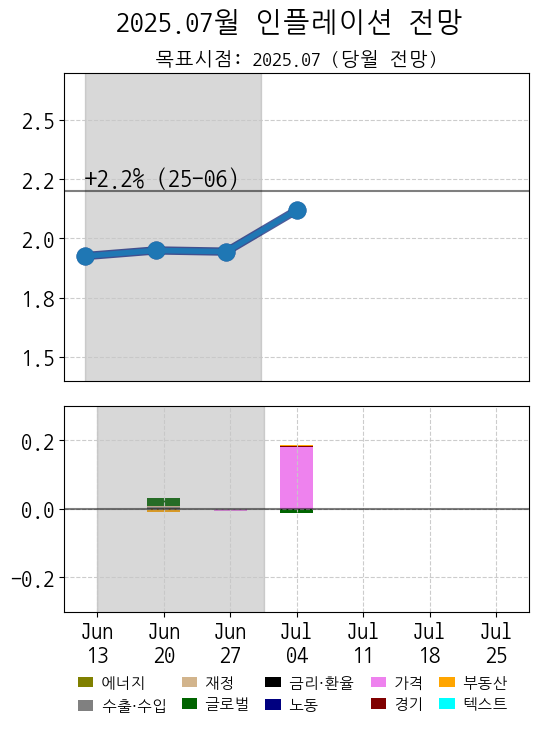

In [19]:
present_results = True
is_Actual = False
year_month = this_month if present_results else '2024-2-1'
    
fm = pd.Timestamp(year_month) + MonthEnd() # 최근 cpi 공표된 다음달

fig, axs = plt.subplots(2, 1, figsize=(6, 7), gridspec_kw={'height_ratios': [3, 2], 'hspace': 0.1})
#, gridspec_kw={'width_ratios': [3, 3, 3], 'height_ratios': [5, 3], 'wspace': 0.15, 'hspace': 0.15})

margin = 0.5 #0.5
margin0 = 0.1 #0.1

DECOMP_VAR = {}
print_decomp_var = True

vspec = pd.read_excel(f'{input_s3_dir}/data_list_all_v9.xlsx', index_col = None) # v5
vspec.index.names = [None]
vspec['group'] = vspec['My ID'].str.split('_', expand=True)[0]
id_group = vspec[['My ID', 'group']].set_index('My ID').to_dict()['group']

df = pd.read_csv(f'{vintage_s3_dir}/{today:%Y-%m-%d}.csv', index_col=0)
df.index = pd.to_datetime(df.index)

_, act = get_train_data_v5(df)
act = act.dropna()

pm = fm - MonthEnd(1)

try:
    ymax = act.loc[pm]
    ymin = act.loc[pm]
except KeyError: # 첫째주 금요일 되기 전까지
    pm = fm - MonthEnd(2)
    ymax = act.loc[pm]
    ymin = act.loc[pm]

dymax = 0
dymin = 0

for i, h in enumerate([0]):
    tm = fm + MonthEnd(h)

    PRED_DECOMP = pd.read_pickle(f"{output_s3_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    if DO_TRAIN and not has_s3key():
        PRED_DECOMP = pd.read_pickle(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    pred_decomp_mean = PRED_DECOMP.groupby(level=1, axis=1).sum()
    pred_decomp_mean = (pred_decomp_mean / len(PRED_DECOMP.columns.get_level_values(0).unique()))
    DECOMP_VAR[h] = pred_decomp_mean
    decomp = pred_decomp_mean.rename(columns=id_group)
    decomp = decomp.groupby(decomp.columns, axis=1).sum()

    _, act_vintage = get_train_data_v5(DF_vintages[decomp.index[-1]])
    
    today_str = today.strftime('%Y-%m-%d')
    #print(today_str)

    last_inf = act_vintage.dropna().iloc[-1] # 12월은 당월 공표되어 -2로
    #print(act_vintage)

    forecast = decomp.pop('forecast') # decomp => forecast + decomp
    decomp = decomp.reindex(columns=vspec.group.unique())
    decomp = decomp.rename(columns={'LM':'IE', 'S':'RE', 'C':'PB'})
    decomp = decomp.groupby(decomp.columns, axis=1).sum()
    decomp = decomp.rename(columns={'EG':'에너지', 'EI':r'수출$\cdot$수입', 'F':'재정', 'GB':'글로벌',
                                    'IE':r'금리$\cdot$환율', 'L':'노동', 'P':'가격', 'PB':'경기', 'RE':'부동산','T':'텍스트'})

    df = pd.concat([forecast, decomp], axis=1)
    df = df.reindex(sorted(list(set(df.index.tolist() + [Nth_friday(fm.year, fm.month, i) for i in [-4, -3, -2, -1]]))))
    ticklabels = [t.strftime("%b\n%d") for t in df.index]
    df.index = np.arange(len(df.index))
    
    bcolors = [(218 / 256, 238 / 256, 243 / 256), (242 / 256, 220 / 256, 219 / 256), (142 / 256, 186 / 256, 66 / 256),
               (192 / 256, 0 / 256, 0 / 256), (0 / 256, 0 / 256, 0 / 256), (251 / 256, 193 / 256, 94 / 256), 
               (33 / 256, 89 / 256, 103 / 256), (119 / 256, 119 / 256, 119 / 256), (255 / 256, 165 / 256, 0 / 256), (0 / 256, 255 / 256, 255 / 256)]
    bcolors = ['olive', 'grey', 'tan', 'darkgreen', 'black', 'navy', 'violet', 'maroon', 'orange', 'cyan']
    
    bok_blue = (0 / 256, 145 / 256, 218 / 256)

    df['forecast'].plot(ax=axs[0], lw=6, marker="o", color=(0.01, 0.09, 0.44), markersize=12, alpha=0.7, label='앙상블') #color=(0.01, 0.09, 0.44)
    axs[0].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b') # color='b'
    axs[0].plot(ticklabels, df.iloc[:, 0], lw=4, marker="o", markersize=12)
    df.iloc[:, 1:].plot.bar(stacked=True, ax=axs[1], color=bcolors)
    axs[1].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[1].set_xticklabels(ticklabels, rotation=0)
    axs[0].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[0].axhline(y=round(last_inf, 1), lw=1.5, color='k', alpha=0.5)
    axs[1].axhline(y=0, lw=1.5, color='k', alpha=0.5)
    ymin = min(df.iloc[:, 0].min().min(), ymin)
    ymax = max(df.iloc[:, 0].max().max(), ymax)
    dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max().max(), dymax)
    #axs[0].legend(ncol= 1, loc='lower left', frameon=False, fontsize=11) #, bbox_to_anchor=(0.3, 0.15) #앙상블 범례에 안나오게
    #axs[1].legend(ncol=14, loc=3, frameon=False, bbox_to_anchor=(0.2, -0.5), fontsize=14) # 0.08
    axs[1].legend(ncol=5, loc=3, frameon=False, fontsize=11, bbox_to_anchor=(0, -0.57), handlelength=1, handletextpad=0.5, columnspacing=1)
    axs[0].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    axs[1].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    
    if h == 0:
        axs[0].set_title(f"목표시점: {tm:%Y.%m} (당월 전망)", fontsize=14)
    else:
        axs[0].set_title(f"{tm:%Y.%m} \n({h}개월 전망)", fontsize=16)
    axs[0].tick_params(axis="both", labelsize=16)
    axs[1].tick_params(axis="both", labelsize=16)
    axs[0].get_xaxis().set_visible(False)
    axs[0].text(0.0, round(last_inf, 1), f"{last_inf:+.1f}% ({pm:%y-%m})", fontsize=17,
                       horizontalalignment='left', verticalalignment='bottom')
    if is_Actual:
        if i > 0:
            axs[0].get_legend().remove()
            axs[1].get_legend().remove()
        try:
            axs[0].text(0.95, 0.93, f"실제값: {act.loc[tm]:+.1f}% ({act.loc[tm]-act.loc[pm]:+.1f}%p)", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0].transAxes)
        except:
            axs[0].text(0.95, 0.93, f"실제값: NA", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0].transAxes)

    axs[0].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)
    axs[1].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)

for i, h in enumerate([0]):
    axs[0].set_ylim(round(ymin - margin, 1), round(ymax + margin, 1))
    axs[1].set_ylim(round(-dymax - margin0, 1), round(dymax + margin0, 1))
    
fig.suptitle(f"{fm:%Y.%m}월 인플레이션 전망", fontsize=20, y=0.97)
fig.savefig(f"{local_path}/inf_mail/inf_{fm:%Y.%m}_rtf_h0.png", dpi='figure', bbox_inches='tight')    

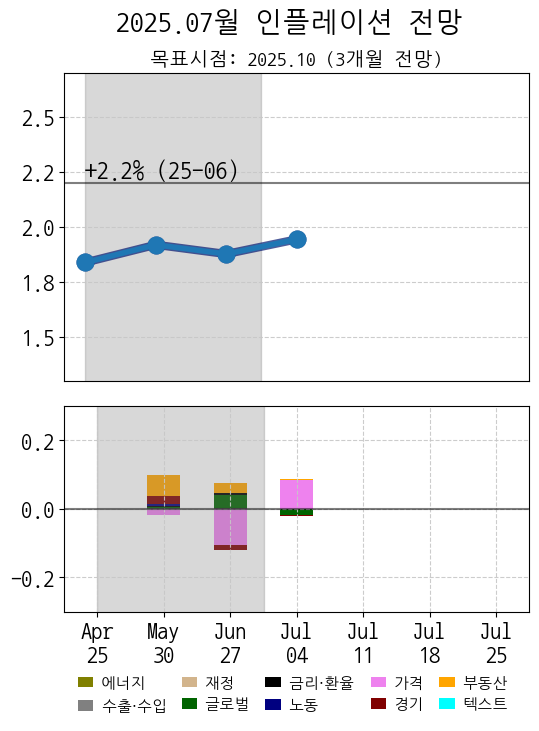

In [20]:
present_results = True
is_Actual = False
year_month = this_month if present_results else '2024-1-1'
    
fm = pd.Timestamp(year_month) + MonthEnd() # 최근 cpi 공표된 다음달

fig, axs = plt.subplots(2, 1, figsize=(6, 7), gridspec_kw={'height_ratios': [3, 2], 'hspace': 0.1})
#, gridspec_kw={'width_ratios': [3, 3, 3], 'height_ratios': [5, 3], 'wspace': 0.15, 'hspace': 0.15})

margin = 0.5 #0.5
margin0 = 0.1 #0.1

DECOMP_VAR = {}
print_decomp_var = True

vspec = pd.read_excel(f'{input_s3_dir}/data_list_all_v9.xlsx', index_col = None)
vspec.index.names = [None]
vspec['group'] = vspec['My ID'].str.split('_', expand=True)[0]
id_group = vspec[['My ID', 'group']].set_index('My ID').to_dict()['group']

df = pd.read_csv(f'{vintage_s3_dir}/{today:%Y-%m-%d}.csv', index_col=0)
df.index = pd.to_datetime(df.index)

_, act = get_train_data_v5(df)
act = act.dropna()

pm = fm - MonthEnd(1)

try:
    ymax = act.loc[pm]
    ymin = act.loc[pm]
except KeyError: # 첫째주 금요일 되기 전까지
    pm = fm - MonthEnd(2)
    ymax = act.loc[pm]
    ymin = act.loc[pm]

dymax = 0
dymin = 0

for i, h in enumerate([3]):
    tm = fm + MonthEnd(h)

    PRED_DECOMP = pd.read_pickle(f"{output_s3_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    if DO_TRAIN and not has_s3key():
        PRED_DECOMP = pd.read_pickle(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    pred_decomp_mean = PRED_DECOMP.groupby(level=1, axis=1).sum()
    pred_decomp_mean = (pred_decomp_mean / len(PRED_DECOMP.columns.get_level_values(0).unique()))
    DECOMP_VAR[h] = pred_decomp_mean
    decomp = pred_decomp_mean.rename(columns=id_group)
    decomp = decomp.groupby(decomp.columns, axis=1).sum()

    _, act_vintage = get_train_data_v5(DF_vintages[decomp.index[-1]])
    today_str = today.strftime('%Y-%m-%d')
    #print(today_str)

    last_inf = act_vintage.dropna().iloc[-1] # 12월은 당월 공표되어 -2로
    #print(act_vintage)

    forecast = decomp.pop('forecast') # decomp => forecast + decomp
    decomp = decomp.reindex(columns=vspec.group.unique())
    decomp = decomp.rename(columns={'LM':'IE', 'S':'RE', 'C':'PB'})
    decomp = decomp.groupby(decomp.columns, axis=1).sum()
    decomp = decomp.rename(columns={'EG':'에너지', 'EI':r'수출$\cdot$수입', 'F':'재정', 'GB':'글로벌',
                                    'IE':r'금리$\cdot$환율', 'L':'노동', 'P':'가격', 'PB':'경기', 'RE':'부동산','T':'텍스트'})

    df = pd.concat([forecast, decomp], axis=1)
    df = df.reindex(sorted(list(set(df.index.tolist() + [Nth_friday(fm.year, fm.month, i) for i in [-4, -3, -2, -1]]))))
    ticklabels = [t.strftime("%b\n%d") for t in df.index]
    df.index = np.arange(len(df.index))
    
    bcolors = [(218 / 256, 238 / 256, 243 / 256), (242 / 256, 220 / 256, 219 / 256), (142 / 256, 186 / 256, 66 / 256),
               (192 / 256, 0 / 256, 0 / 256), (0 / 256, 0 / 256, 0 / 256), (251 / 256, 193 / 256, 94 / 256), 
               (33 / 256, 89 / 256, 103 / 256), (119 / 256, 119 / 256, 119 / 256), (255 / 256, 165 / 256, 0 / 256), (0 / 256, 255 / 256, 255 / 256)]
    bcolors = ['olive', 'grey', 'tan', 'darkgreen', 'black', 'navy', 'violet', 'maroon', 'orange', 'cyan']
    
    bok_blue = (0 / 256, 145 / 256, 218 / 256)

    df['forecast'].plot(ax=axs[0], lw=6, marker="o", color=(0.01, 0.09, 0.44), markersize=12, alpha=0.7, label='앙상블') #color=(0.01, 0.09, 0.44)
    axs[0].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b') # color='b'
    axs[0].plot(ticklabels, df.iloc[:, 0], lw=4, marker="o", markersize=12)
    df.iloc[:, 1:].plot.bar(stacked=True, ax=axs[1], color=bcolors)
    axs[1].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[1].set_xticklabels(ticklabels, rotation=0)
    axs[0].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[0].axhline(y=round(last_inf, 1), lw=1.5, color='k', alpha=0.5)
    axs[1].axhline(y=0, lw=1.5, color='k', alpha=0.5)
    ymin = min(df.iloc[:, 0].min().min(), ymin)
    ymax = max(df.iloc[:, 0].max().max(), ymax)
    dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max().max(), dymax)
    #axs[0].legend(ncol= 1, loc='lower left', frameon=False, fontsize=11) # , bbox_to_anchor=(0.3, 0.15)########################
    #axs[1].legend(ncol=14, loc=3, frameon=False, bbox_to_anchor=(0.2, -0.5), fontsize=14) # 0.08
    axs[1].legend(ncol=5, loc=3, frameon=False, fontsize=11, bbox_to_anchor=(0, -0.57), handlelength=1, handletextpad=0.5, columnspacing=1)
    axs[0].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    axs[1].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    
    if h == 0:
        axs[0].set_title(f"목표시점: {tm:%Y.%m} (당월 전망)", fontsize=14)
    else:
        axs[0].set_title(f"목표시점: {tm:%Y.%m} ({h}개월 전망)", fontsize=14)
    axs[0].tick_params(axis="both", labelsize=16)
    axs[1].tick_params(axis="both", labelsize=16)
    axs[0].get_xaxis().set_visible(False)
    axs[0].text(0.0, round(last_inf, 1), f"{last_inf:+.1f}% ({pm:%y-%m})", fontsize=17,
                       horizontalalignment='left', verticalalignment='bottom')
    
    if is_Actual:
        if i > 0:
            axs[0].get_legend().remove()
            axs[1].get_legend().remove()
        try:
            axs[0].text(0.95, 0.93, f"실제값: {act.loc[tm]:+.1f}% ({act.loc[tm]-act.loc[pm]:+.1f}%p)", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0].transAxes)
        except:
            axs[0].text(0.95, 0.93, f"실제값: NA", fontsize=17,
                           horizontalalignment='right', verticalalignment='center', transform=axs[0].transAxes)

    axs[0].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)
    axs[1].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)

for i, h in enumerate([3]):
    axs[0].set_ylim(round(ymin - margin, 1), round(ymax + margin, 1))
    axs[1].set_ylim(round(-dymax - margin0, 1), round(dymax + margin0, 1))
    
fig.suptitle(f"{fm:%Y.%m}월 인플레이션 전망", fontsize=20, y=0.97)
fig.savefig(f"{local_path}/inf_mail/inf_{fm:%Y.%m}_rtf_h3.png", dpi='figure', bbox_inches='tight')    

# 변동요인분해 결과 저장

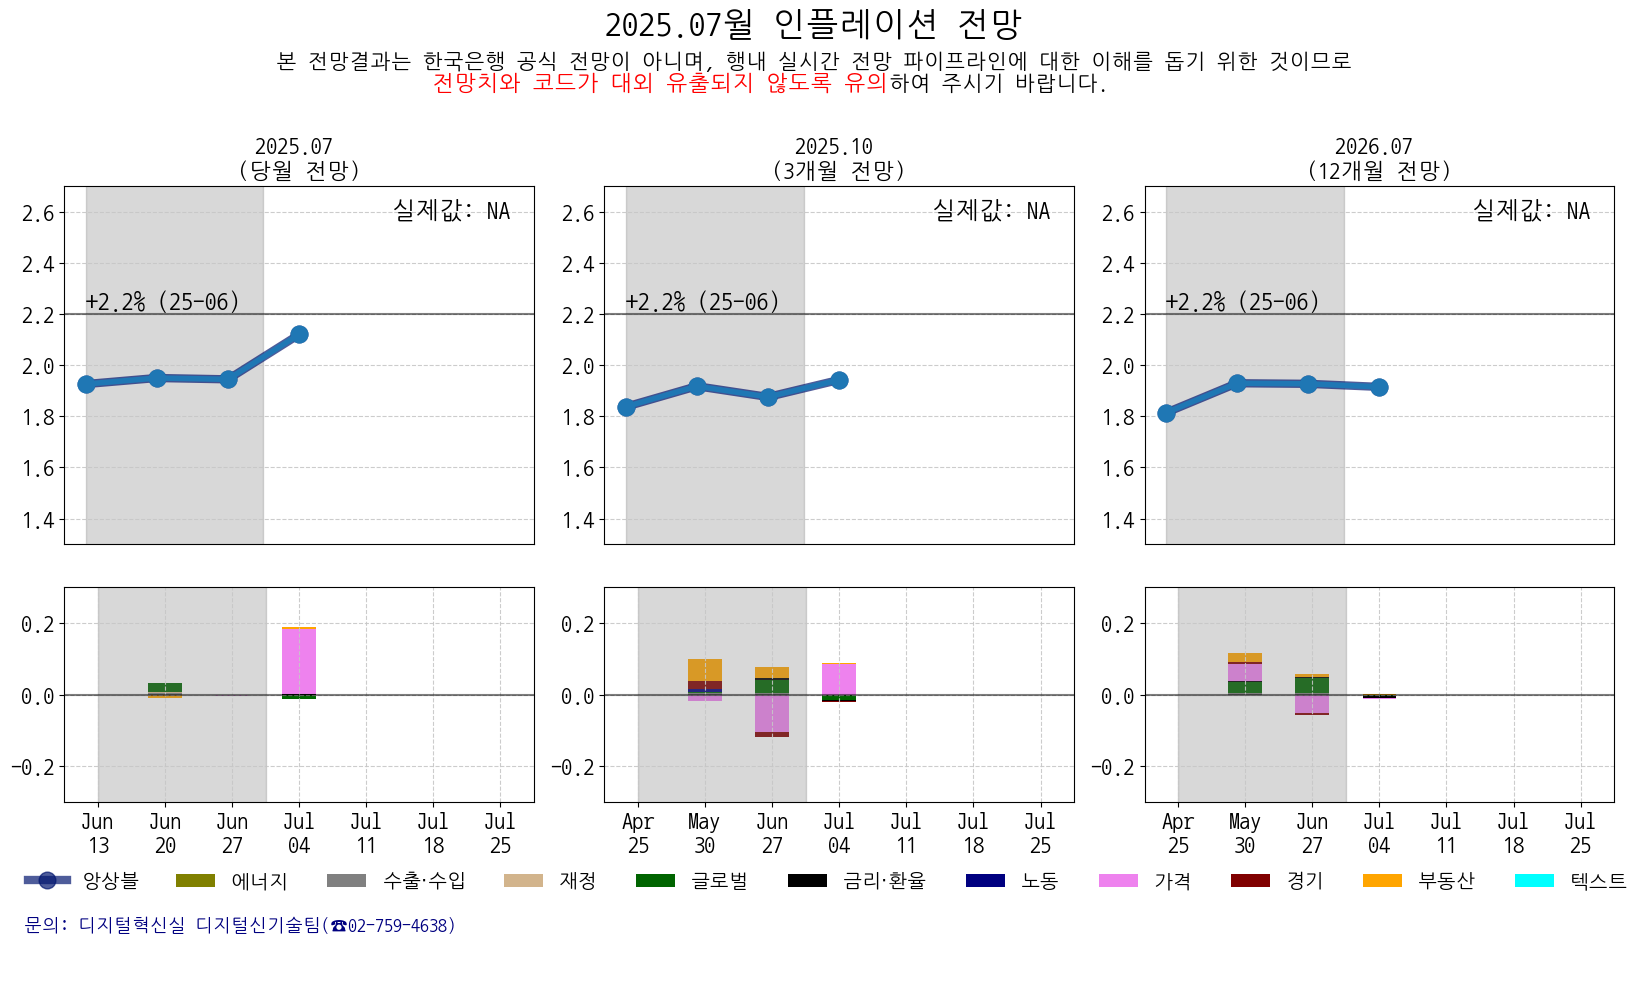

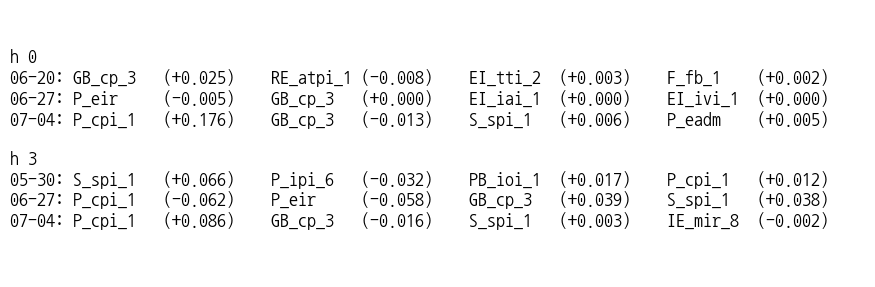

In [21]:
present_results = True
year_month = this_month if present_results else '2024-1-1'
    
fm = pd.Timestamp(year_month) + MonthEnd() # 최근 cpi 공표된 다음달

fig, axs = plt.subplots(2, 3, figsize=(20, 8),
                        gridspec_kw={'width_ratios': [3, 3, 3], 'height_ratios': [5, 3],
                                     'wspace': 0.15, 'hspace': 0.15})
margin = 0.5
margin0 = 0.1

DECOMP_VAR = {}
print_decomp_var = True

vspec = pd.read_excel(f'{input_s3_dir}/data_list_all_v9.xlsx', index_col = None) #v5
vspec.index.names = [None]
vspec['group'] = vspec['My ID'].str.split('_', expand=True)[0]
id_group = vspec[['My ID', 'group']].set_index('My ID').to_dict()['group']

df = pd.read_csv(f'{vintage_s3_dir}/{today:%Y-%m-%d}.csv', index_col=0)
df.index = pd.to_datetime(df.index)

_, act = get_train_data_v5(df)
act = act.dropna()

pm = fm - MonthEnd(1)

try:
    ymax = act.loc[pm]
    ymin = act.loc[pm]
except KeyError: # 첫째주 금요일 되기 전까지
    pm = fm - MonthEnd(2)
    ymax = act.loc[pm]
    ymin = act.loc[pm]

dymax = 0
dymin = 0

for i, h in enumerate([0, 3, 12]):
    tm = fm + MonthEnd(h)

    PRED_DECOMP = pd.read_pickle(f"{output_s3_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    if DO_TRAIN and not has_s3key():
        PRED_DECOMP = pd.read_pickle(f"{output_dir}/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    pred_decomp_mean = PRED_DECOMP.groupby(level=1, axis=1).sum()
    pred_decomp_mean = (pred_decomp_mean / len(PRED_DECOMP.columns.get_level_values(0).unique()))
    DECOMP_VAR[h] = pred_decomp_mean
    decomp = pred_decomp_mean.rename(columns=id_group)
    decomp = decomp.groupby(decomp.columns, axis=1).sum()

    _, act_vintage = get_train_data_v5(DF_vintages[decomp.index[-1]])
    
    today_str = today.strftime('%Y-%m-%d')
    #print(today_str)

    last_inf = act_vintage.dropna().iloc[-1] # 12월은 당월 공표되어 -2로
    #print(act_vintage)
    
#     if present_results:
#         inf = pd.read_csv(f'{input_s3_dir}/mdata/{today_str}_raw.csv', index_col = None) #{today_str}_raw.csv
#         inf = inf['P_cpi_1']
#         inf = inf.dropna()
#         inf = inf.pct_change(12)*100
#         last_inf = inf.iloc[-1]
#     else:
#         last_inf = act_vintage.dropna().iloc[-1]

    forecast = decomp.pop('forecast') # decomp => forecast + decomp
    decomp = decomp.reindex(columns=vspec.group.unique())
    decomp = decomp.rename(columns={'LM':'IE', 'S':'RE', 'C':'PB'})
    decomp = decomp.groupby(decomp.columns, axis=1).sum()
    decomp = decomp.rename(columns={'EG':'에너지', 'EI':r'수출$\cdot$수입', 'F':'재정', 'GB':'글로벌',
                                    'IE':r'금리$\cdot$환율', 'L':'노동', 'P':'가격', 'PB':'경기', 'RE':'부동산','T':'텍스트'})

    df = pd.concat([forecast, decomp], axis=1)
    df = df.reindex(sorted(list(set(df.index.tolist() + [Nth_friday(fm.year, fm.month, i) for i in [-4, -3, -2, -1]]))))
    ticklabels = [t.strftime("%b\n%d") for t in df.index]
    df.index = np.arange(len(df.index))
    
    bcolors = [(218 / 256, 238 / 256, 243 / 256), (242 / 256, 220 / 256, 219 / 256), (142 / 256, 186 / 256, 66 / 256),
               (192 / 256, 0 / 256, 0 / 256), (0 / 256, 0 / 256, 0 / 256), (251 / 256, 193 / 256, 94 / 256), 
               (33 / 256, 89 / 256, 103 / 256), (119 / 256, 119 / 256, 119 / 256), (255 / 256, 165 / 256, 0 / 256), (0 / 256, 255 / 256, 255 / 256)]
    bcolors = ['olive', 'grey', 'tan', 'darkgreen', 'black', 'navy', 'violet', 'maroon', 'orange', 'cyan']
    
    bok_blue = (0 / 256, 145 / 256, 218 / 256)

    df['forecast'].plot(ax=axs[0, i], lw=6, marker="o", color=(0.01, 0.09, 0.44), markersize=12, alpha=0.7, label='앙상블') #color=(0.01, 0.09, 0.44)
    axs[0, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b') # color='b'
    axs[0, i].plot(ticklabels, df.iloc[:, 0], lw=4, marker="o", markersize=12)
    df.iloc[:, 1:].plot.bar(stacked=True, ax=axs[1, i], color=bcolors)
    axs[1, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[1, i].set_xticklabels(ticklabels, rotation=0)
    axs[0, i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[1, i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[0, i].axhline(y=round(last_inf, 1), lw=1.5, color='k', alpha=0.5)
    axs[1, i].axhline(y=0, lw=1.5, color='k', alpha=0.5)
    ymin = min(df.iloc[:, 0].min().min(), ymin)
    ymax = max(df.iloc[:, 0].max().max(), ymax)
    dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max().max(), dymax)
    axs[0, i].legend(ncol= 1, loc=1, frameon=False, bbox_to_anchor=(0.2, -0.869), fontsize=14) #########################
    axs[1, i].legend(ncol=14, loc=3, frameon=False, bbox_to_anchor=(0.2, -0.5), fontsize=14) # 0.08
    axs[0, i].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    axs[1, i].grid(axis="both", color=(200 / 256, 200 / 256, 200 / 256), linestyle="--", alpha=0.9)
    
    if h == 0:
        axs[0, i].set_title(f"{tm:%Y.%m} \n(당월 전망)", fontsize=16)
    else:
        axs[0, i].set_title(f"{tm:%Y.%m} \n({h}개월 전망)", fontsize=16)
    axs[0, i].tick_params(axis="both", labelsize=16)
    axs[1, i].tick_params(axis="both", labelsize=16)
    axs[0, i].get_xaxis().set_visible(False)
    axs[0, i].text(0.0, round(last_inf, 1), f"{last_inf:+.1f}% ({pm:%y-%m})", fontsize=17,
                       horizontalalignment='left', verticalalignment='bottom')
    if i > 0:
        axs[0, i].get_legend().remove()
        axs[1, i].get_legend().remove()
    try:
        axs[0, i].text(0.95, 0.93, f"실제값: {act.loc[tm]:+.1f}% ({act.loc[tm]-act.loc[pm]:+.1f}%p)", fontsize=17,
                       horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)
    except:
        axs[0, i].text(0.95, 0.93, f"실제값: NA", fontsize=17,
                       horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)

    axs[0, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)
    axs[1, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)

for i, h in enumerate([0, 3, 12]):
    axs[0, i].set_ylim(round(ymin - margin, 1), round(ymax + margin, 1))
    axs[1, i].set_ylim(round(-dymax - margin0, 1), round(dymax + margin0, 1))
    
fig.suptitle(f"{fm:%Y.%m}월 인플레이션 전망", fontsize=24, y=1.1)

text4 = '\n\n문의: 디지털혁신실 디지털신기술팀(☎02-759-4638)\n\n'
fig.text(0.105, -0.1, f'{text4}', fontsize=13, color='navy') # 0., -.15,

warning = [
    "본 전망결과는 한국은행 공식 전망이 아니며, 행내 실시간 전망 파이프라인에 대한 이해를 돕기 위한 것이므로\n",
    "전망치와 코드가 대외 유출되지 않도록 유의",
    "하여 주시기 바랍니다."]

for i, text in enumerate(warning):
    x_position = 0.423 if i == 1 else 0.5 if i == 0 else 0.592
    color = 'red' if i == 1 else 'black'
    fontsize = 16 if i == 1 else 15
    fig.text(x_position, 1, text, transform=fig.transFigure, ha='center', fontsize=fontsize, color=color)

#fig.savefig(f"{local_path}/plot/inf_{fm:%Y.%m}_rtf.png", dpi='figure', bbox_inches='tight')    
    
fig, ax = plt.subplots(1, 1, figsize=(3,3)) ########수정
text = ''
for h in [0, 3]:
    text += f"\n\nh {h} "
    #print(f"\n\nforecasting horizon: {h}", end='')
    df = DECOMP_VAR[h].drop('forecast', axis=1)
    for i in df.index[1:]:
        vars = np.abs(df).loc[i].nlargest(4).index
        text += f"\n{i:%m-%d}:\t"
        #print(f"\n{i:%m-%d}:", end='\t')
        for v in vars:
            text += f"{v:<10}({df.loc[i, v]:+.3f})    "

if print_decomp_var:
    fig.text(0, 1, text, fontsize=13, horizontalalignment='left', verticalalignment='top') # 0.106, -0.03
ax.axis('off')

fig.savefig(f"{local_path}/inf_mail/inf_{fm:%Y.%m}_var.png", dpi='figure', bbox_inches='tight')